### [TSFresh for Time Series Feature Extraction](https://towardsdev.com/tsfresh-for-time-series-feature-extraction-in-python-c4ee791f467c)

> TSFresh automates feature extraction from time series data by calculating hundreds of statistical characteristics and selecting the most relevant ones for machine learning tasks.

**_TSFresh (Time Series Feature Extraction based on Scalable Hypothesis tests)_** is designed to automatically extract features from time series data. These features are useful for ML tasks like classification, regression, and anomaly detection. So, by automating feature extraction, TSFresh saves us time (in theory).

**_Automating Feature Extraction_** goes through hundreds of features like mean, variance, skewness, and autocorrelation, and then filters out irrelevant or redundant features based on statistical tests. It works with univariate or multivariate time series data.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas matplotlib seaborn
!pip install -q tsfresh scikit-learn

In [3]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction.feature_calculators import mean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a larger sample dataset
np.random.seed(42)
n_series = 100
n_timepoints = 100
time_series_list = []
for i in range(n_series):
    frequency = np.random.uniform(0.5, 2)
    phase = np.random.uniform(0, 2*np.pi)
    noise_level = np.random.uniform(0.05, 0.2)
    
    values = np.sin(frequency * np.linspace(0, 10, n_timepoints) + phase) + np.random.normal(0, noise_level, n_timepoints)
    
    df = pd.DataFrame({
        'id': i,
        'time': range(n_timepoints),
        'value': values
    })
    time_series_list.append(df)
time_series = pd.concat(time_series_list, ignore_index=True)
print("Original time series data:")
print(time_series.head())
print(f"Number of time series: {n_series}")
print(f"Number of timepoints per series: {n_timepoints}")

Original time series data:
   id  time     value
0   0     0 -0.482423
1   0     1 -0.150078
2   0     2 -0.050430
3   0     3  0.173569
4   0     4  0.026236
Number of time series: 100
Number of timepoints per series: 100


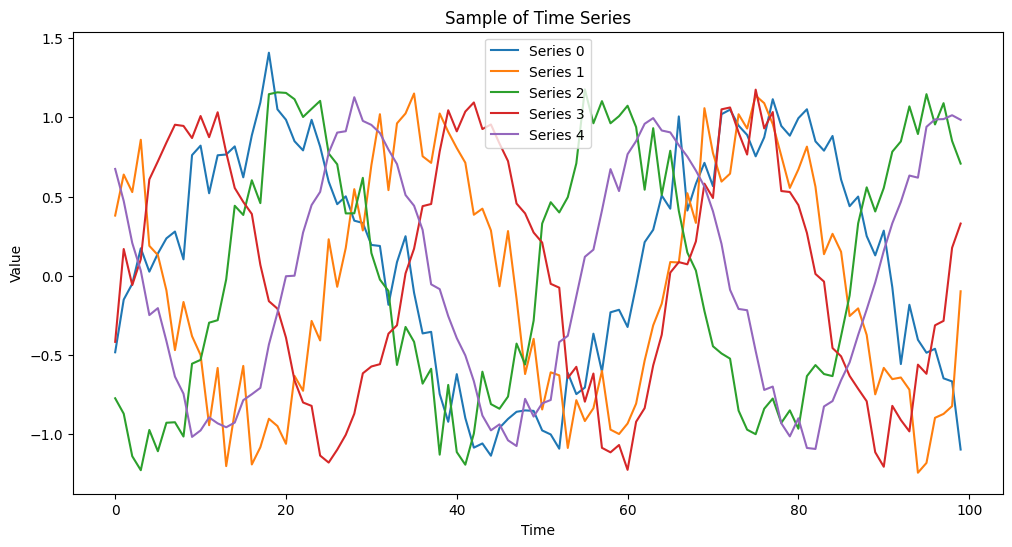

In [4]:
# Visualize some of the time series
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot first 5 time series
    plt.plot(time_series[time_series['id'] == i]['time'], 
             time_series[time_series['id'] == i]['value'], 
             label=f'Series {i}')
plt.title('Sample of Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
# plt.savefig("sample_TS.png")
plt.show()

In [5]:
# Extract features
features = extract_features(time_series, column_id="id", column_sort="time", n_jobs=0)
print("\nExtracted features:")
print(features.head())

# Impute NaN values
features_imputed = impute(features)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]



Extracted features:
   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       0.0                   0.0          13.730541   
1                       0.0                   0.0          -5.803774   
2                       0.0                   0.0           1.294975   
3                       0.0                   0.0           0.700599   
4                       0.0                   0.0          -3.002320   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
0  

In [6]:
# Create a target variable (classify based on frequency)
target = pd.Series(index=range(n_series), dtype=int)
target[features_imputed.index % 2 == 0] = 0  # Even indices
target[features_imputed.index % 2 == 1] = 1  # Odd indices

# Select relevant features
selected_features = select_features(features_imputed, target)

# If no features were selected, use all features
if selected_features.empty:
    print("\nNo features were selected. Using all features.")
    selected_features = features_imputed
else:
    print("\nSelected features:")
    print(selected_features.head())

print(f"\nNumber of features: {selected_features.shape[1]}")
print("\nNames of features (first 10):")
print(selected_features.columns.tolist()[:10])


No features were selected. Using all features.

Number of features: 783

Names of features (first 10):
['value__variance_larger_than_standard_deviation', 'value__has_duplicate_max', 'value__has_duplicate_min', 'value__has_duplicate', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median']



Classification Model Performance:
Accuracy: 0.20

Classification Report:
              precision    recall  f1-score   support

         0.0       0.25      0.17      0.20        12
         1.0       0.17      0.25      0.20         8

    accuracy                           0.20        20
   macro avg       0.21      0.21      0.20        20
weighted avg       0.22      0.20      0.20        20



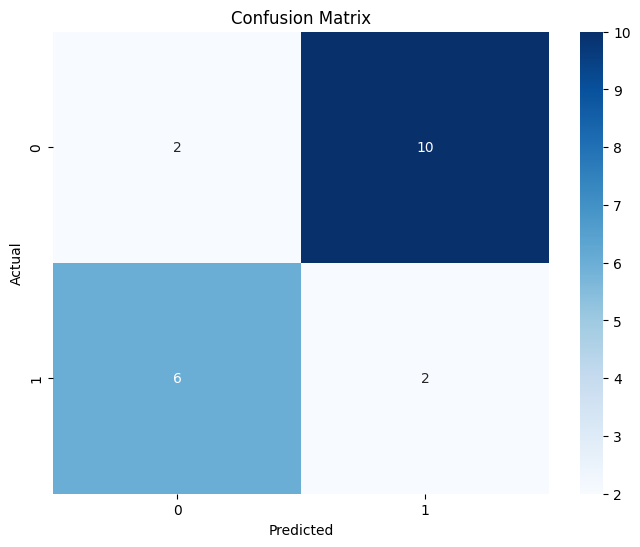

In [7]:
# Classification part
# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    selected_features, target, test_size=0.2, random_state=42
)
# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Evaluate the classification model
y_pred_clf = clf.predict(X_test_clf)

print("\nClassification Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.2f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf))

# Visualize confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig("confusion_matrix.png")
plt.show()


Top 10 Most Important Features:
                                               feature  importance
253  value__change_quantiles__f_agg_"mean"__isabs_F...    0.015687
695  value__agg_linear_trend__attr_"rvalue"__chunk_...    0.011564
499       value__fft_coefficient__attr_"abs"__coeff_34    0.011095
88                              value__quantile__q_0.6    0.010287
133  value__cwt_coefficients__coeff_0__w_10__widths...    0.010276
606     value__fft_coefficient__attr_"angle"__coeff_41    0.010182
273       value__fft_coefficient__attr_"real"__coeff_8    0.008727
719  value__agg_linear_trend__attr_"slope"__chunk_l...    0.008713
607     value__fft_coefficient__attr_"angle"__coeff_42    0.008147
84                              value__quantile__q_0.1    0.008061


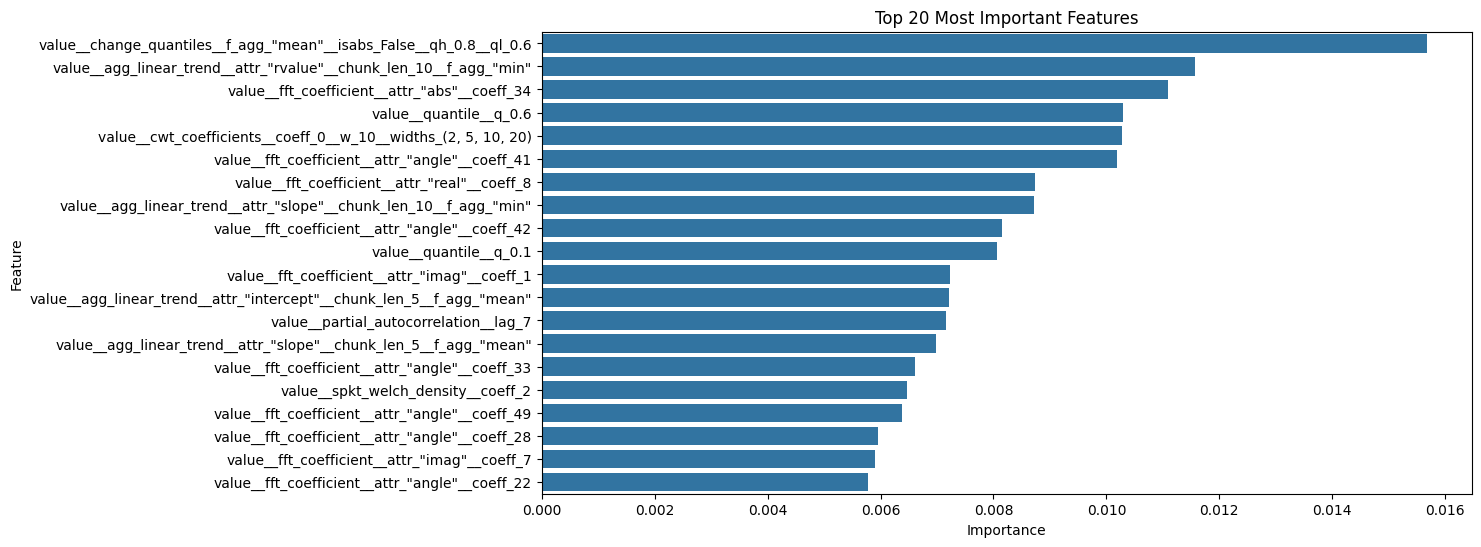

In [8]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_clf.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.savefig("feature_importance.png")
plt.show()

In [9]:
# Multivariate feature extraction

# Add another variable to the dataset
time_series["value2"] = time_series["value"] * 0.5 + np.random.normal(0, 0.05, len(time_series))

# Extract features from both variables
features_multivariate = extract_features(
    time_series, 
    column_id="id", 
    column_sort="time", 
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=0
)
print("\nMultivariate features:")
print(features_multivariate.head())

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.15it/s]



Multivariate features:
   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       0.0                   0.0          13.730541   
1                       0.0                   0.0          -5.803774   
2                       0.0                   0.0           1.294975   
3                       0.0                   0.0           0.700599   
4                       0.0                   0.0          -3.002320   

   value__abs_energy  value__mean_abs_change  value__mean_change  \



Custom features (mean of each time series, first 5):
id
0    0.137305
1   -0.058038
2    0.012950
3    0.007006
4   -0.030023
Name: value, dtype: float64


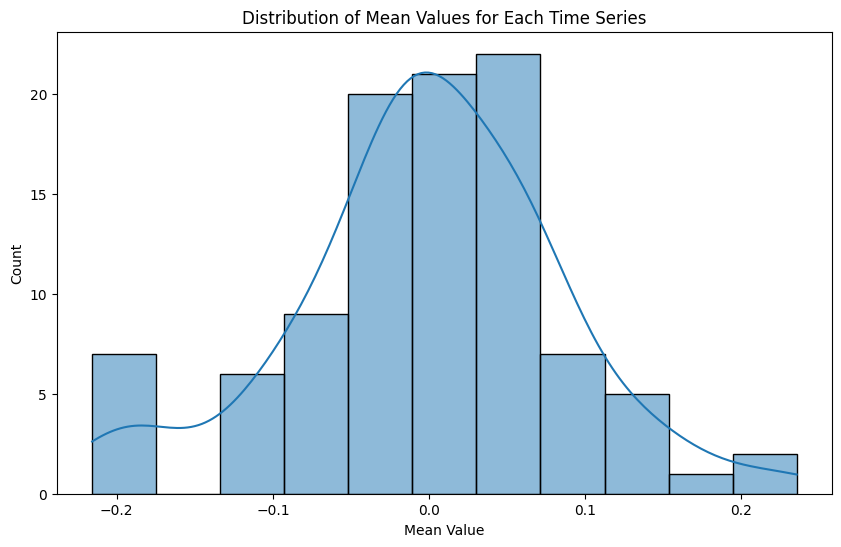

In [10]:
# Compute the mean for each time series
custom_features = time_series.groupby("id")["value"].apply(mean)
print("\nCustom features (mean of each time series, first 5):")
print(custom_features.head())

# Visualize the distribution of custom features
plt.figure(figsize=(10, 6))
sns.histplot(custom_features, kde=True)
plt.title('Distribution of Mean Values for Each Time Series')
plt.xlabel('Mean Value')
plt.ylabel('Count')
# plt.savefig("dist_of_means_TS.png")
plt.show()

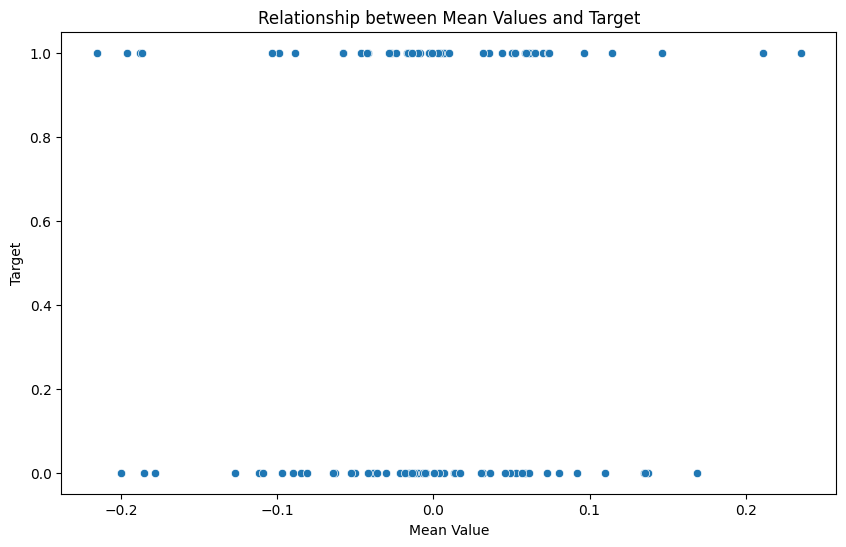

In [11]:
# Visualize the relationship between custom features and target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=custom_features, y=target)
plt.title('Relationship between Mean Values and Target')
plt.xlabel('Mean Value')
plt.ylabel('Target')
# plt.savefig("means_v_target_TS.png")
plt.show()